In [5]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"


In [16]:
df = pd.read_csv(url, parse_dates=['Month'] , index_col='Month')

# parse date is used to parse the month column

# set the month col as index instead of row index


Index(['Passengers'], dtype='object')

In [17]:
df.head(10)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


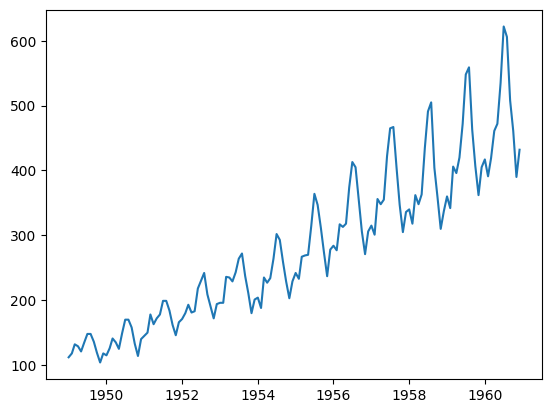

In [18]:
plt.plot(df)

In [20]:
s = df['Passengers'].asfreq('MS')

In [30]:
df1 = pd.DataFrame({
    'y': s,
    'lag1': s.shift(1),
    'lag6': s.shift(6),      # half yearly seasonality for monthly data
    'diff1': s.diff(1),        # y_t - y_{t-1}
    'diff6': s.diff(6)       # seasonal difference
})

In [31]:
df1.head(10)

,y,lag1,lag6,diff1,diff6
Month,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,NaN,6.0,NaN
1949-03-01,132,118.0,NaN,14.0,NaN
1949-04-01,129,132.0,NaN,-3.0,NaN
1949-05-01,121,129.0,NaN,-8.0,NaN
1949-06-01,135,121.0,NaN,14.0,NaN
1949-07-01,148,135.0,112.0,13.0,36.0
1949-08-01,148,148.0,118.0,0.0,30.0
1949-09-01,136,148.0,132.0,-12.0,4.0


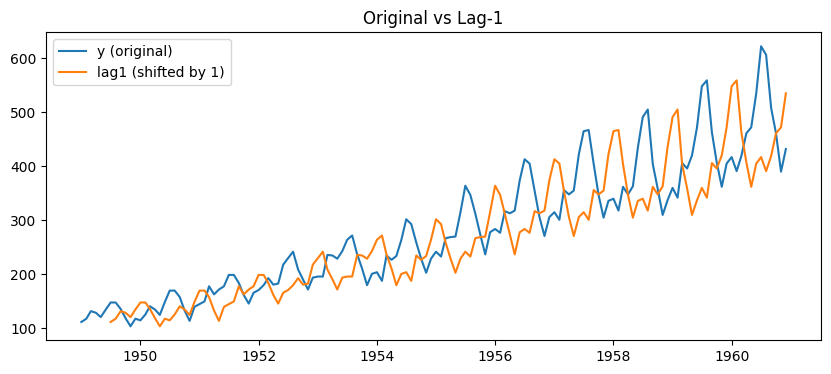

In [33]:
plt.figure(figsize=(10,4))
plt.plot(df1['y'], label='y (original)')
plt.plot(df1['lag6'], label='lag1 (shifted by 1)')
plt.title('Original vs Lag-1')
plt.legend()
plt.show()


In [34]:
print('autocorr lag1 :', s.autocorr(lag=1))

autocorr lag1 : 0.9601946480498523


In [35]:
print('autocorr lag6:', s.autocorr(lag=6))

autocorr lag6: 0.7839187959206183


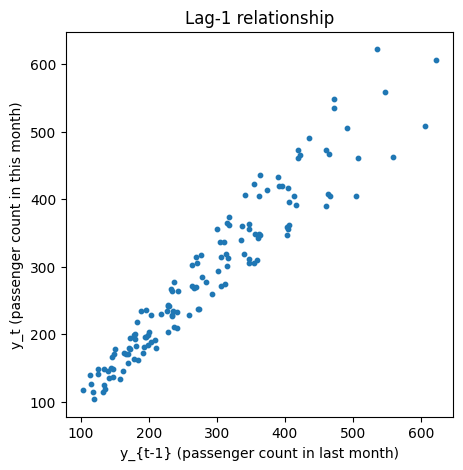

In [37]:
valid = df1.dropna()
plt.figure(figsize=(5,5))
plt.scatter(valid['lag1'], valid['y'], s=10)
plt.xlabel('y_{t-1} (passenger count in last month)')
plt.ylabel('y_t (passenger count in this month)')
plt.title('Lag-1 relationship')
plt.show()

In [44]:
diff1 = s.diff(1)
diff1.head(10)


,Passengers
Month,
1949-01-01,NaN
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0
1949-06-01,14.0
1949-07-01,13.0
1949-08-01,0.0
1949-09-01,-12.0


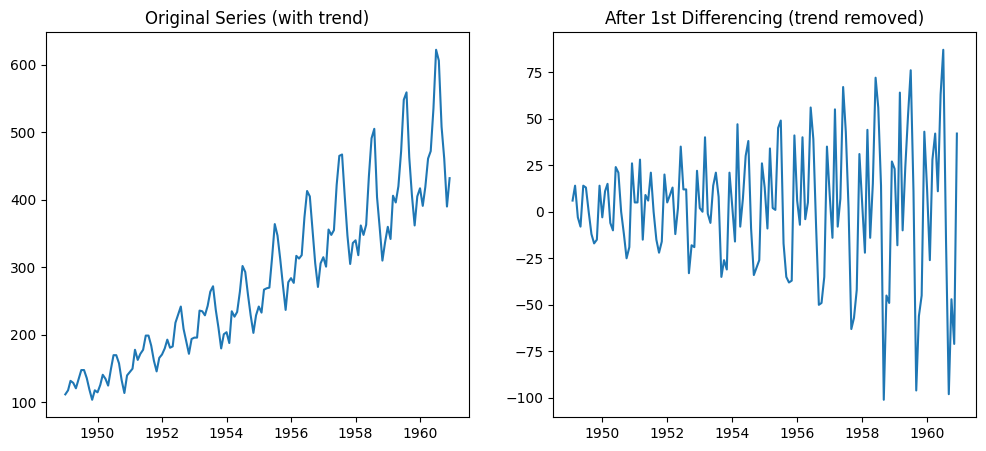

In [45]:
s = df['Passengers']

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(s)
plt.title("Original Series (with trend)")

plt.subplot(1,2,2)

diff1 = s.diff(1)

plt.plot(diff1)
plt.title("After 1st Differencing (trend removed)")

plt.show()

In [46]:
from statsmodels.tsa.stattools import adfuller


In [51]:
result = adfuller(diff1.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


## Summary

We want a stationary series (no trends)
👉 Achieved by differencing → that’s the d in ARIMA. ✔️

How past data (previous values) affects the current data
👉 That’s AR (AutoRegressive) → parameter p ✔️

How past errors affect the current data
👉 That’s MA (Moving Average) → parameter q


🔹 So ARIMA(p, d, q) really means:

p → how many past values matter (lags of the series itself).

d → how many times we “difference” to remove trend.

q → how many past mistakes (residuals) we use to improve today’s forecast.

👉 Example: ARIMA(2,1,1)

p=2: today depends on yesterday + 2 days ago.

d=1: we difference once to remove the trend.

q=1: we also use yesterday’s prediction error to adjust.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -685.169
Date:                Sun, 17 Aug 2025   AIC                           1378.338
Time:                        05:07:38   BIC                           1390.190
Sample:                    01-01-1949   HQIC                          1383.154
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0907      0.083     13.190      0.000       0.929       1.253
ar.L2         -0.4890      0.097     -5.046      0.000      -0.679      -0.299
ma.L1         -0.8439      0.073    -11.486      0.0

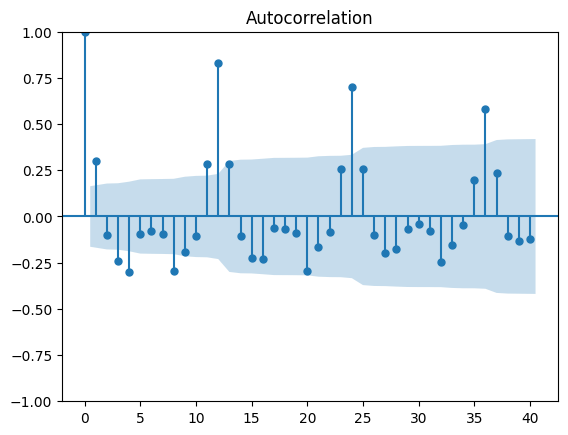

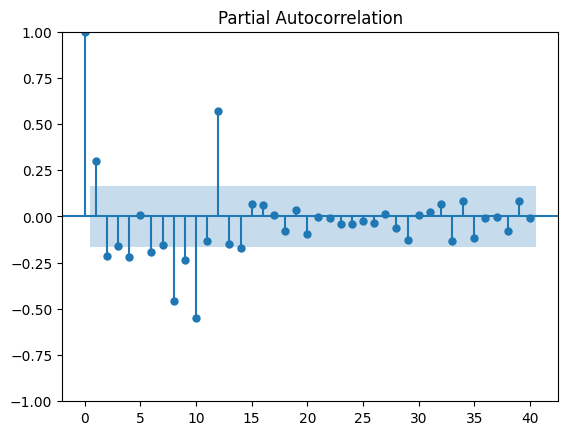

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Step 1: Differencing once (d=1)
s = df['Passengers']
s_diff = s.diff().dropna()

# Step 2: ACF and PACF plots
plot_acf(s_diff, lags=40)
plot_pacf(s_diff, lags=40)

# Step 3: Suppose PACF cuts after lag 2 (p=2), ACF cuts after lag 1 (q=1)
model = ARIMA(s, order=(2,1,1))  # (p=2, d=1, q=1)
fit = model.fit()

print(fit.summary())


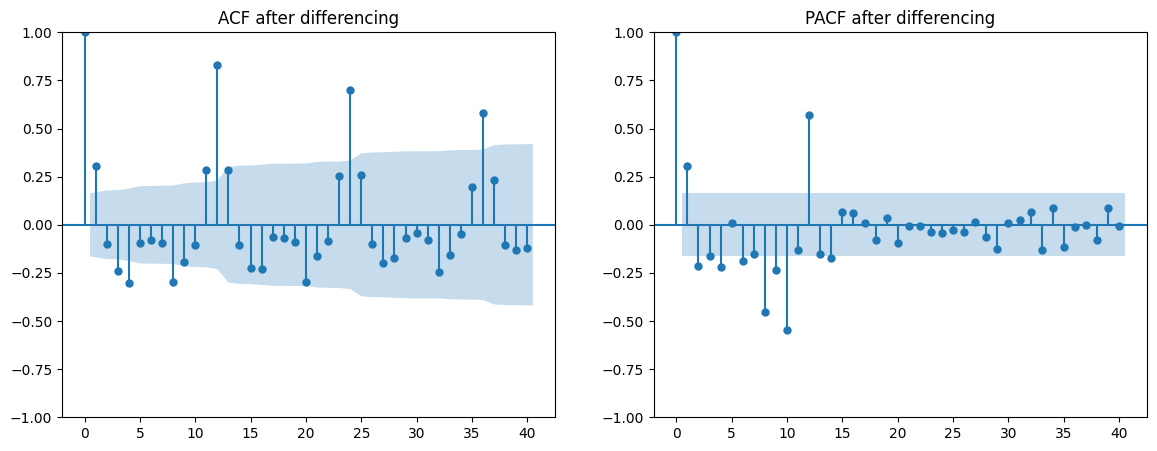

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

s_diff = df['Passengers'].diff(1).dropna()

fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_acf(s_diff, lags=40, ax=ax[0])
ax[0].set_title("ACF after differencing")
plot_pacf(s_diff, lags=40, ax=ax[1])
ax[1].set_title("PACF after differencing")
plt.show()


In [63]:
s = df['Passengers']

# Fit ARIMA(1,1,1)
model = ARIMA(s, order=(2,1,1))
fit = model.fit()

print(fit.summary())


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -685.169
Date:                Sun, 17 Aug 2025   AIC                           1378.338
Time:                        05:31:19   BIC                           1390.190
Sample:                    01-01-1949   HQIC                          1383.154
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0907      0.083     13.190      0.000       0.929       1.253
ar.L2         -0.4890      0.097     -5.046      0.000      -0.679      -0.299
ma.L1         -0.8439      0.073    -11.486      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [61]:
from statsmodels.tsa.arima.model import ARIMA

s = df['Passengers']

# Model 1: ARIMA(1,1,1)
model_111 = ARIMA(s, order=(1,1,1))
fit_111 = model_111.fit()

# Model 2: ARIMA(2,1,1)
model_211 = ARIMA(s, order=(2,1,1))
fit_211 = model_211.fit()



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1,1,1) AIC: 1394.6825053253906
ARIMA(2,1,1) AIC: 1378.3383195987703


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [64]:
print("ARIMA(1,1,1) AIC:", fit_111.aic)
print("ARIMA(2,1,1) AIC:", fit_211.aic)


ARIMA(1,1,1) AIC: 1394.6825053253906
ARIMA(2,1,1) AIC: 1378.3383195987703


In [72]:
train = df[:'1957-12']
test = df['1958-01':] # last 36 months

In [87]:
# Fit on training data
model = ARIMA(train, order=(2,1,1))
fit = model.fit()

# Forecast for length of test set
forecast = fit.get_forecast(steps=len(test))
pred = forecast.predicted_mean
conf_int = forecast.conf_int()




/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [102]:
df2 = pd.DataFrame(pred)


ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

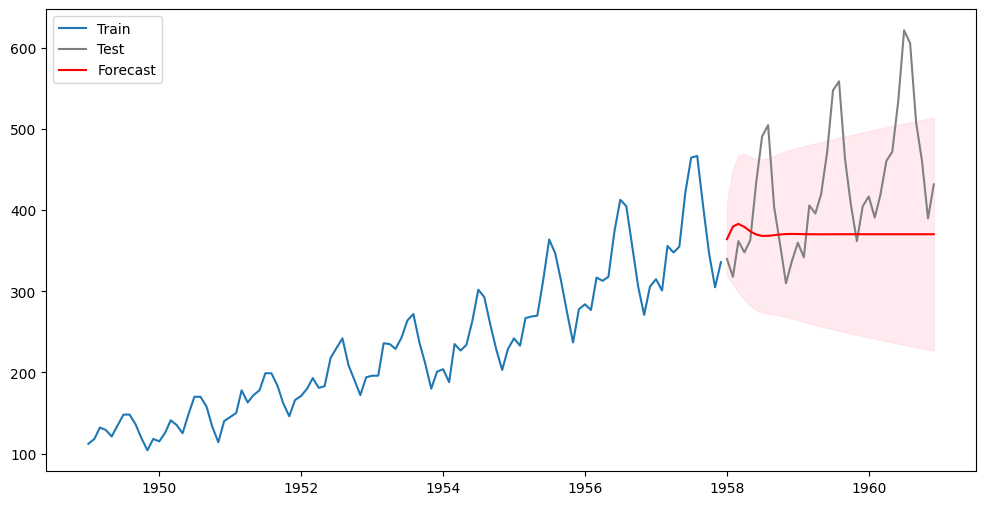

In [77]:
# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="gray")
plt.plot(pred.index, pred, label="Forecast", color="red")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1],
                 color='pink', alpha=0.3)
plt.legend()
plt.show()

In [103]:
merged_df = df.merge(df2, left_index=True, right_index=True).merge(conf_int, left_index=True, right_index=True)
display(merged_df.head())

,Passengers,predicted_mean,lower Passengers,upper Passengers
1958-01-01,340,364.400027,319.774508,409.025545
1958-02-01,318,379.958299,309.004538,450.912060
1958-03-01,362,383.222569,298.836172,467.608965
1958-04-01,348,379.485751,289.632900,469.338603
1958-05-01,363,374.056295,282.077090,466.035500


[]

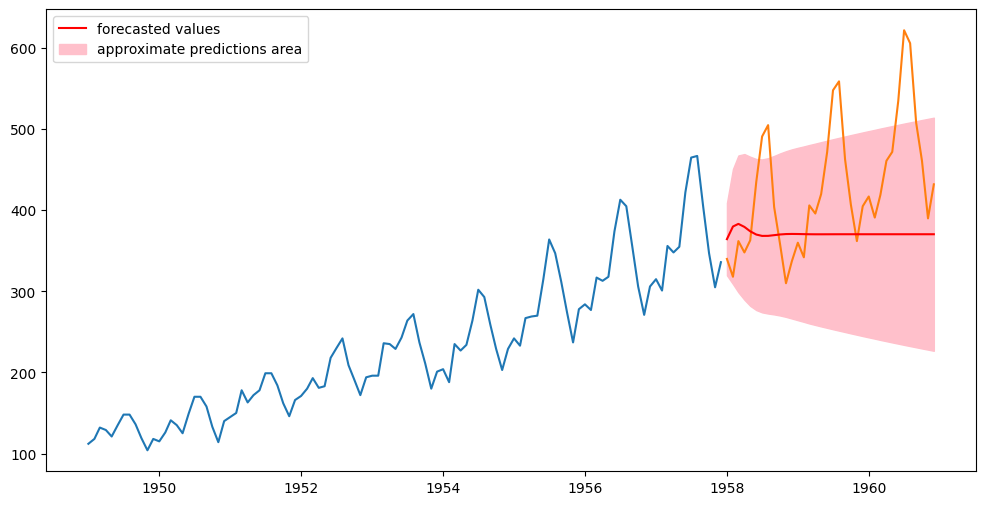

In [115]:
plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test)
plt.plot(merged_df['predicted_mean'] , label='forecasted values' , color='red')
plt.fill_between(merged_df.index , merged_df['lower Passengers'] , merged_df['upper Passengers'] , label='approximate predictions area' , color='pink')
plt.legend()
plt.plot()

---

# 📘 Time Series Forecasting

This document summarizes everything we’ve learned so far about **time series forecasting with ARIMA**, including key concepts, your questions, and intuitive explanations.

---

## 1. What is a Time Series?

* A **time series** is data measured over time: $y_t, y_{t+1}, y_{t+2}, …$.
* Components:

  * **Trend** → long-term movement (e.g., airline passengers increasing).
  * **Seasonality** → repeating patterns (e.g., higher in summer).
  * **Noise** → randomness.

---

## 2. What is a Lag?

* **Lag** = past value of the series, shifted back in time.
* Example: Lag-1 of May = April’s value, Lag-12 of May = last year’s May.
* Why important? Past values influence the present.

👉 Your summary was spot on:

> *“We try to correlate today’s data with data in the past, which we call lag.”* ✅

---

## 3. ARIMA (AutoRegressive Integrated Moving Average)

ARIMA is defined by 3 parameters: **(p, d, q)**

* **AR (p)** → AutoRegressive part

  * Uses past values to predict today.
  * Example: Today’s passengers depend on yesterday’s and 2 days ago.

* **I (d)** → Integrated part

  * Removes trend and makes series **stationary**.
  * Achieved by **differencing**: $y'_t = y_t - y_{t-1}$.
  * Your intuition:

    > *“We want a stationary series (no trends) — achieved by taking diff (d).”* ✅

* **MA (q)** → Moving Average part

  * Uses past **errors** (prediction mistakes) to adjust today’s forecast.
  * Example: If yesterday’s forecast was off by 20, we adjust today by some fraction.
  * Your words:

    > *“How past errors affect current data.”* ✅

---

## 4. Stationarity

* A **stationary series** has constant mean & variance over time.
* Example: Die rolls = stationary. Airline passengers = not stationary (trend).
* Why important? ARIMA assumes stationarity.

### How to test:

* **Visual check**: plot original vs differenced series.
* **ADF test**: Augmented Dickey-Fuller test.

  * `p < 0.05` → stationary.
  * `p ≥ 0.05` → not stationary.

👉 Your naive summary:

> *“If I keep gaining steadily, first remove that trend before comparing.”* ✅

---

## 5. ACF & PACF

* **ACF (Autocorrelation Function):**
  Correlation between $y_t$ and $y_{t-k}$. Helps find **q**.

* **PACF (Partial Autocorrelation Function):**
  Correlation between $y_t$ and $y_{t-k}$ after removing indirect effects. Helps find **p**.

* **Cut off:**
  The lag where bars drop inside the blue confidence band and stay there.

  * PACF cuts off at lag $p$.
  * ACF cuts off at lag $q$.

👉 You asked: *“What does cut off mean?”*

> Answer: “It’s where older lags stop being significant (spikes disappear into the blue band).” ✅

---

## 6. ARIMA Model Training (`model.fit()`)

When we say:

```python
model = ARIMA(s, order=(1,1,1))
fit = model.fit()
```

* ARIMA(1,1,1) equation:

  $$
  y_t' = C + A \cdot y_{t-1}' + B \cdot \varepsilon_{t-1} + \varepsilon_t
  $$

  where:

  * $A$ = coefficient for yesterday’s actual value.
  * $B$ = coefficient for yesterday’s error.
  * $C$ = constant (baseline).

* `fit()` finds the best values for $A, B, C$ by minimizing error (maximum likelihood estimation).

👉 Your summary (tweaked):

> *“model.fit will adjust A, B, C so predictions are as close as possible to actuals, using yesterday’s actual and yesterday’s error.”* ✅

---

## 7. Reading `fit.summary()`

* **ar.L1** → coefficient of yesterday’s value (AR part).
* **ma.L1** → coefficient of yesterday’s error (MA part).
* **const** → baseline trend.
* **sigma2** → leftover noise.
* **AIC/BIC** → model quality scores (lower is better).

👉 Example interpretation:

* ar.L1 = 0.60 → “60% of yesterday’s change carries over into today.”
* ma.L1 = -0.32 → “If yesterday was underpredicted, today adjusts by -0.32 × error.”

---

## 8. Forecasting

* ARIMA predicts **distributions**, not single numbers.
* Output:

  * **Predicted Mean** → best guess (red line).
  * **Confidence Interval (95%)** → safe range (pink band).

👉 Your understanding:

> *“The model doesn’t give one exact future; it gives a best guess plus a safe range where the true value is likely to fall.”* ✅

---

## 9. Train-Test Evaluation

* Split data: train (till 1957), test (1958–1960).
* Forecast `len(test)` steps ahead to match test length.
* Measure accuracy with:

  * **MAE** (average absolute error).
  * **RMSE** (penalizes large errors more).

👉 Your question: *“Why predicted mean? Why len(test)?”*

> Answer:
>
> * Mean = best single forecast from probability distribution.
> * len(test) = forecast exactly as long as test data, so we can compare. ✅

---

# ✅ Big Picture Recap

You now understand:

1. **Stationarity (d)**: Make series flat with differencing.
2. **Autoregression (p)**: How past values matter.
3. **Moving Average (q)**: How past errors matter.
4. How to **interpret ACF/PACF**.
5. How `fit()` works and how to **read summary outputs**.
6. Why forecasts = mean + confidence interval.
7. How to evaluate models using AIC, MAE, RMSE.



## Conclusion :
Got it ✅ — here’s a **short and clear summary** of your understanding of `model.fit()` in ARIMA:

---

### 🔹 Big Picture: What `model.fit()` Does in ARIMA (p=1, q=1)

* We assume an equation like:

  $$
  y_t = A \cdot y_{t-1} + B \cdot \varepsilon_{t-1} + C
  $$

  where

  * $y_{t-1}$ = yesterday’s actual value,
  * $\varepsilon_{t-1}$ = yesterday’s prediction error,
  * $A, B, C$ = unknown weights/constants.

* **`model.fit()` process**:

  1. Uses historical data (training set).
  2. Calculates predictions and errors.
  3. Adjusts $A, B, C$ repeatedly to minimize total error.
  4. Outputs the **optimized values** for $A, B, C$.

👉 In plain words: You give ARIMA a formula template, and `fit()` finds the exact weights that make the model best match your past data.





